Import the neccessary libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

Data Loading

In [20]:
# Define the filename provided by the user
FILE_NAME = "combined_data_laliga.csv"
RANDOM_STATE = 42 # For reproducibility

print(f"Loading data from {FILE_NAME}")

# load the dataset
try:
    df = pd.read_csv("combined_data_laliga.csv")
    print("Data loaded successfully!")
except FileNotFoundError:
    print("Error: 'combined_data_laliga.csv' was not found")

Loading data from combined_data_laliga.csv
Data loaded successfully!


In [21]:
# Set pandas options to display all columns 
pd.set_option("display.max_columns",None)
print("Data loaded successfully. First 5 rows")
df.head()

Data loaded successfully. First 5 rows


,Unnamed: 0,Home Team,Away Team,Score,Half Time Score,Match Excitement,Home Team Rating,Away Team Rating,Home Team Possession %,Away Team Possession %,Home Team Off Target Shots,Home Team On Target Shots,Home Team Total Shots,Home Team Blocked Shots,Home Team Corners,Home Team Throw Ins,Home Team Pass Success %,Home Team Aerials Won,Home Team Clearances,Home Team Fouls,Home Team Yellow Cards,Home Team Second Yellow Cards,Home Team Red Cards,Away Team Off Target Shots,Away Team On Target Shots,Away Team Total Shots,Away Team Blocked Shots,Away Team Corners,Away Team Throw Ins,Away Team Pass Success %,Away Team Aerials Won,Away Team Clearances,Away Team Fouls,Away Team Yellow Cards,Away Team Second Yellow Cards,Away Team Red Cards,Home Team Goals Scored,Away Team Goals Scored,Home Team Goals Conceeded,Away Team Goals Conceeded,year
0,0,MÁLAGA,ATHLETIC,1-0,1-0,4.4,6.0,5.7,40,60,5.0,3.0,12.0,4.0,5.0,13.0,69.0,11.0,16.0,13.0,3.0,0.0,2.0,5.0,5.0,12.0,2.0,4.0,22.0,84.0,17.0,14.0,9.0,3.0,0.0,0.0,1,0,0,1,2014
1,1,SEVILLA FC,VALENCIA,1-1,1-0,4.7,6.5,6.8,47,53,4.0,3.0,12.0,5.0,3.0,20.0,76.0,13.0,16.0,23.0,4.0,0.0,0.0,5.0,1.0,11.0,5.0,3.0,27.0,79.0,14.0,16.0,8.0,2.0,0.0,1.0,1,1,1,1,2014
2,2,GRANADA,DEPORTIVO,2-1,0-1,4.6,7.2,5.9,53,47,6.0,3.0,10.0,1.0,5.0,25.0,79.0,20.0,21.0,13.0,1.0,0.0,0.0,1.0,1.0,8.0,6.0,3.0,30.0,76.0,10.0,14.0,26.0,3.0,0.0,0.0,2,1,1,2,2014
3,3,ALMERÍA,ESPANYOL,1-1,0-0,5.6,6.9,5.5,56,44,7.0,6.0,19.0,6.0,11.0,26.0,81.0,19.0,25.0,8.0,3.0,0.0,0.0,6.0,2.0,12.0,4.0,7.0,19.0,70.0,11.0,20.0,9.0,3.0,1.0,0.0,1,1,1,1,2014
4,4,EIBAR,REAL SOCIEDAD,1-0,1-0,3.7,6.5,5.9,41,59,5.0,5.0,12.0,2.0,5.0,28.0,60.0,29.0,17.0,13.0,4.0,0.0,0.0,7.0,4.0,19.0,8.0,6.0,36.0,75.0,25.0,20.0,14.0,1.0,0.0,0.0,1,0,0,1,2014


Data Preprocessing and Feature Engineering

In [22]:
# Create Target Variable
# The target variable is the match result: Home Win (H), Draw (D), or Away Win (A)
def get_match_result(row):
    # Determine the match result based on goals scored
    if row["Home Team Goals Scored"] > row["Away Team Goals Scored"]:
        return "H" # Home Win
    elif row["Home Team Goals Scored"] < row["Away Team Goals Scored"]:
        return "A" # Away Win
    else:
        return "D" # Draw
    
df ["Results"] = df.apply(get_match_result,axis=1)

In [23]:
# Drop columns that are direct indicators of the result or contain redundant information
# We drop 'Score', 'Half Time Score', and the explicit goal columns used to create 'Result'.
# We also drop ID/index columns if present
df.drop(columns=['Score', 'Half Time Score', 'Home Team Goals Scored',
                 'Away Team Goals Scored', 'Home Team Goals Conceeded',
                 'Away Team Goals Conceeded'], errors='ignore', inplace=True)

In [24]:
# Check for missing values 
df_missing = df.isnull().sum()
print("Missing Values")
print(df_missing)

Missing Values
Unnamed: 0                       0
Home Team                        0
Away Team                        0
Match Excitement                 0
Home Team Rating                 0
Away Team Rating                 0
Home Team Possession %           0
Away Team Possession %           0
Home Team Off Target Shots       0
Home Team On Target Shots        0
Home Team Total Shots            0
Home Team Blocked Shots          0
Home Team Corners                0
Home Team Throw Ins              0
Home Team Pass Success %         0
Home Team Aerials Won            0
Home Team Clearances             0
Home Team Fouls                  0
Home Team Yellow Cards           0
Home Team Second Yellow Cards    0
Home Team Red Cards              0
Away Team Off Target Shots       0
Away Team On Target Shots        0
Away Team Total Shots            0
Away Team Blocked Shots          0
Away Team Corners                0
Away Team Throw Ins              0
Away Team Pass Success %         0
Away 

In [25]:
# Check for duplicated rows
df_duplicated = df.duplicated().sum()
print("Duplicated Rows")
print(df_duplicated)

Duplicated Rows
0


In [26]:
# Drop any row with missing values (NaN) to ensure clean data
df.dropna(inplace=True)

In [27]:
# Feature Engineering
# We create features that represent the performance difference between home and away teams

df["Possession_Diff"] = df["Home Team Possession %"] - df["Away Team Possession %"]
df["Shots_On_Target_Diff"] = df["Home Team On Target Shots"] - df["Away Team On Target Shots"]
df["Total_Shots_Diff"] = df["Home Team Total Shots"] - df["Away Team Total Shots"]
df["Fouls_Diff"] = df["Home Team Fouls"] - df["Away Team Fouls"]
df["Corners_Diff"] = df["Home Team Corners"] - df["Away Team Corners"]
df["Pass_Success_Diff"] = df["Home Team Pass Success %"] - df["Away Team Pass Success %"]

# Select the feature matrix (X) and the target variable (y)
# We select the most predictive and engineered features
FEATURES_COLS = [
    "Home Team Rating","Away Team Rating",
    "Possession_Diff","Shots_On_Target_Diff","Total_Shots_Diff",
    "Fouls_Diff","Corners_Diff","Pass_Success_Diff",
    "Home Team Yellow Cards","Away Team Yellow Cards"
]

X = df[FEATURES_COLS]
y = df["Results"]

In [28]:
print("Engineered features used for prediction:")
print(FEATURES_COLS)

Engineered features used for prediction:
['Home Team Rating', 'Away Team Rating', 'Possession_Diff', 'Shots_On_Target_Diff', 'Total_Shots_Diff', 'Fouls_Diff', 'Corners_Diff', 'Pass_Success_Diff', 'Home Team Yellow Cards', 'Away Team Yellow Cards']


In [29]:
print(f"Total instances after cleaning: {len(X)}")

Total instances after cleaning: 2660


Pre-Training Visualization: Feature Correlation

Generating Pre-Trainin Visualization (Correlation Heatmap).....


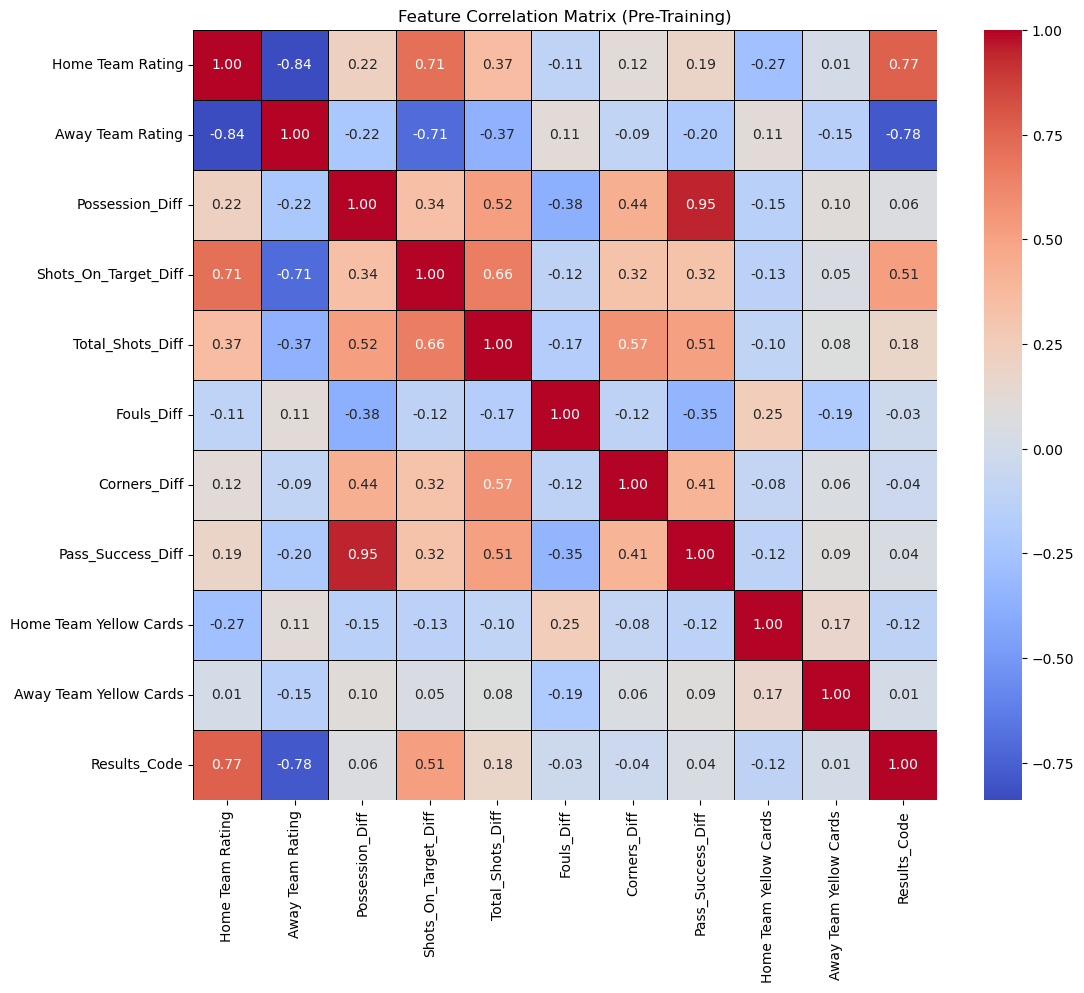

In [30]:
print("Generating Pre-Trainin Visualization (Correlation Heatmap).....")

# Combine features and target for visualization
df_viz = X.copy()
df_viz["Results_Code"] = LabelEncoder().fit_transform(y) # Convert H/D/A to 0/1/2 for correlation

# Calculate the correlation matrix
correlation_matrix = df_viz.corr()

# Plot the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix,annot=True,cmap="coolwarm",fmt=".2f",linewidths=.5,linecolor="black")
plt.title("Feature Correlation Matrix (Pre-Training)")
plt.show()

Data Splitting

In [31]:
# Split the data into training (80%) and testing (20%) sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

Data Scaling

In [32]:
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Label Encoding

In [33]:
# Convert the string labels (H,D,A) to a numerical labels (0,1,2)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.fit_transform(y_test)
target_names = le.classes_ # ["A","D","H"]

Model Training and Comparison

In [34]:
# Initialize a dictionary of models to compare
models = {
    "Logistic Regression":LogisticRegression(max_iter=1000,random_state=RANDOM_STATE),
    "K-Nearest Neigbours": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=5,random_state=RANDOM_STATE),
    "Random Forest":RandomForestClassifier(n_estimators=100,max_depth=8,random_state=RANDOM_STATE),
    "Support Vector Machine (SVC)": SVC(kernel="rbf",probability=True,random_state=RANDOM_STATE)
}


results = {}
best_model_name = ""
best_accuracy = 0.0
best_model = None

print("----- Starting Model Training and Evaluation -----")

for name,model in models.items():
    # Train the model using the scaled training data
    model.fit(X_train_scaled,y_train_encoded)

    # Predict on the test set
    y_pred_encoded = model.predict(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_encoded,y_pred_encoded)
    results[name] = accuracy

    # Print detailed report
    print(f"----- {name} Results -----")
    print(f"Accuracy: {accuracy:.4f}")

    # Decode the numerical predictions back to H, D, A for the report
    y_pred_labels = le.inverse_transform(y_pred_encoded)
    print(classification_report(y_test,y_pred_labels,target_names=target_names))


    # Identify the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name
        best_model = model

print("-"*50)
print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy:.4f}")
print("-"*50)

----- Starting Model Training and Evaluation -----
----- Logistic Regression Results -----
Accuracy: 0.8534
              precision    recall  f1-score   support

           A       0.92      0.82      0.87       175
           D       0.63      0.75      0.68       110
           H       0.93      0.93      0.93       247

    accuracy                           0.85       532
   macro avg       0.83      0.83      0.83       532
weighted avg       0.87      0.85      0.86       532

----- K-Nearest Neigbours Results -----
Accuracy: 0.7669
              precision    recall  f1-score   support

           A       0.82      0.74      0.78       175
           D       0.47      0.57      0.51       110
           H       0.90      0.87      0.89       247

    accuracy                           0.77       532
   macro avg       0.73      0.73      0.73       532
weighted avg       0.78      0.77      0.77       532

----- Decision Tree Results -----
Accuracy: 0.8139
              precisio

Post-Training Visualization: Model Comparison

Generating Post-Training Visualization (Model Comparison)....


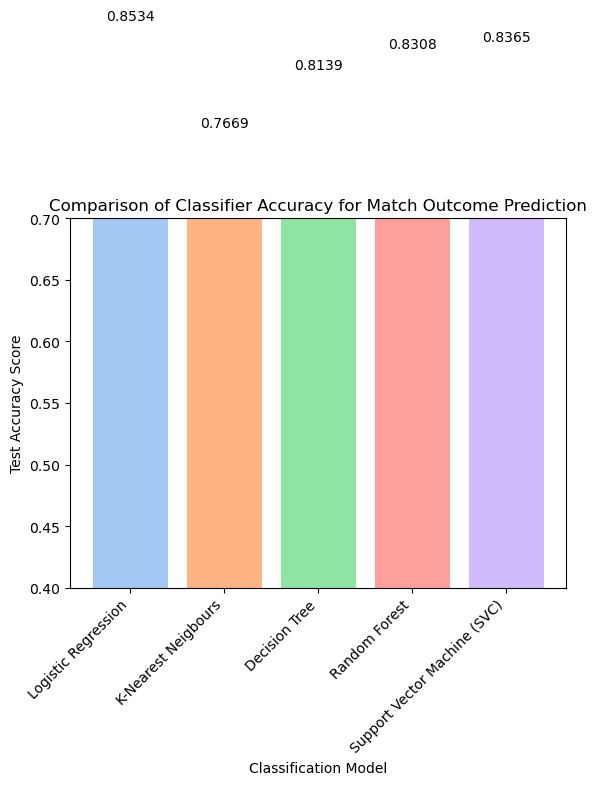

In [35]:
print("Generating Post-Training Visualization (Model Comparison)....")

# Convert results dictionary to a format suitable for plotting
model_names = list(results.keys())
accuracies = [results[name] for name in model_names]

#plt.figure(figsize=(10,6))
bars = plt.bar(model_names,accuracies,color=sns.color_palette("pastel"))
plt.xlabel("Classification Model")
plt.ylabel("Test Accuracy Score")
plt.title("Comparison of Classifier Accuracy for Match Outcome Prediction")
plt.ylim(0.4,0.7) 

# Add text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{yval:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45,ha="right")
#plt.tight_layout()
plt.show()

Interactive Prediction Input (using the Best Model)

In [ ]:
if best_model is not None:
    print(f"Interactive Prediction using the Best Model: {best_model_name}")

    # Define a helper function to get input safely
    def get_float_input(prompt):
        while True:
            try:
                return float(input(prompt))
            except ValueError:
                print("Invalid input. Please enter a numerical value")
                break

    # Gather required inputs from the user
    print("Please input the match statistics for a new game (hypothetical data):")

    # Team Ratings
    home_rating = get_float_input("Home Team Rating (e.g., 7.5):")
    away_rating = get_float_input("Away Team Rating (eg,. 6.2):")

    # Key Statistical Differentals (Average/Expected differences)
    # The actual features used are the differences, which are calculated below
    home_possession = get_float_input("Home Team Possession % (e.g., 55):")
    away_possession = get_float_input("Away Team Possession % (e.g., 45): ")

    home_shots_on_target = get_float_input("Home Team On Target Shots (e.g., 6.0): ")
    away_shots_on_target = get_float_input("Away Team On Target Shots (e.g., 3.0): ")

    home_total_shots = get_float_input("Home Team Total Shots (e.g., 15.0): ")
    away_total_shots = get_float_input("Away Team Total Shots (e.g., 8.0): ")

    home_fouls = get_float_input("Home Team Fouls committed (e.g., 12.0): ")
    away_fouls = get_float_input("Away Team Fouls committed (e.g., 15.0): ")

    home_corners = get_float_input("Home Team Corners (e.g., 7.0): ")
    away_corners = get_float_input("Away Team Corners (e.g., 4.0): ")

    home_pass_success = get_float_input("Home Team Pass Success % (e.g., 85.0): ")
    away_pass_success = get_float_input("Away Team Pass Success % (e.g., 78.0): ")

    home_yellow = get_float_input("Home Team Yellow Cards (e.g., 2.0): ")
    away_yellow = get_float_input("Away Team Yellow Cards (e.g., 3.0): ")

    # Calculate Feature Differences
    new_data_dict = {
        'Home Team Rating': [home_rating],
        'Away Team Rating': [away_rating],
        'Possession_Diff': [home_possession - away_possession],
        'Shots_On_Target_Diff': [home_shots_on_target - away_shots_on_target],
        'Total_Shots_Diff': [home_total_shots - away_total_shots],
        'Fouls_Diff': [home_fouls - away_fouls],
        'Corners_Diff': [home_corners - away_corners],
        'Pass_Success_Diff': [home_pass_success - away_pass_success],
        'Home Team Yellow Cards': [home_yellow],
        'Away Team Yellow Cards': [away_yellow]
    }

    # Create a DataFrame for the prediction
    new_match_df = pd.DataFrame(new_data_dict)

    # Scale the new data using the fitted scaler
    new_match_scaled = scaler.transform(new_match_df)

    # Make the prediction (returns an encoded label,e.g., 0, 1 or 2)
    prediction_encoded = best_model.predict(new_match_scaled)[0]

    # Get the prediction probability (only for models that support it, like SVC with probabilty=True)
    if hasattr(best_model,"predict_proba"):
        prediction_proba = best_model.predict_proba(new_match_scaled)[0]
    else:
        # For models without predict_proba or when the probabilty=False in SVC
        prediction_proba = [0,0,0]

    # Decode the numerical prediction back to H, D, or A
    predicted_label = le.inverse_transform([prediction_encoded])[0]

    # Map the prediction to the full outcome text
    outcome_map = {
        "H": "Home Win",
        "D": "Draw",
        "A": "Away Win"
    }
    final_prediction = outcome_map.get(predicted_label,"Unknown")

    print("="*60)
    print(f"Predicted Outcome using {best_model_name}: {final_prediction}")
    print("="*60)

    # Print the probabilities if available
    if hasattr(best_model,"predict_proba"):
        # Match probabilities to the original class names ["A","D","H"]
        proba_df = pd.DataFrame({
            "Outcome":target_names,
            "Probability": prediction_proba
        }).sort_values(by="Probability",ascending=False)
        proba_df["Probability"] = (proba_df["Probability"] * 100).round(2).astype(str) + "%"

        print("Prediction Probabilities:")
        print(proba_df.to_string(index=False))